<a href="https://colab.research.google.com/github/JayeonKangNature/Model_Practice/blob/main/NeRF/NeRF_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper CODE

Download NeRF model from the gitbub in paper

In [ ]:
!git clone https://github.com/yenchenlin/nerf-pytorch.git

Cloning into 'nerf-pytorch'...
remote: Enumerating objects: 458, done.
remote: Total 458 (delta 0), reused 0 (delta 0), pack-reused 458
Receiving objects: 100% (458/458), 3.99 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (263/263), done.


Environment Set-up

In [ ]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

* .npz: The . npz file format is a zipped archive of files named after the variables they contain. The archive is not compressed and each file in the archive contains one variable in . npy format.

* .npy: The . npy format is the standard binary file format in NumPy for persisting a single arbitrary NumPy array on disk.

Checking Input

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


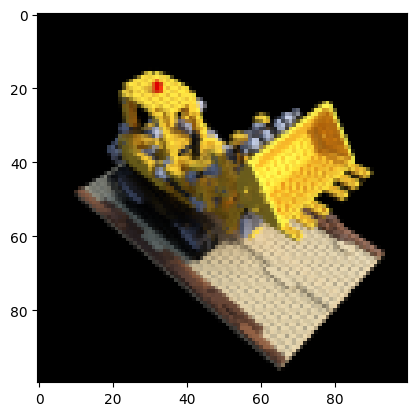

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [ ]:
print(list(data.keys()))

['images', 'poses', 'focal']


In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

**Train**

* PSNR

  The PSNR block computes the peak signal-to-noise ratio, in decibels, between two images. This ratio is used as a quality measurement between the original and a compressed image. The higher the PSNR, the better the quality of the compressed, or reconstructed image.
  
  it has db unit

* What is a good value for PSNR?

  Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, where higher is better. Values over 40 dB are normally considered very good and those below 20 dB are normally unacceptable.
  -> why..?


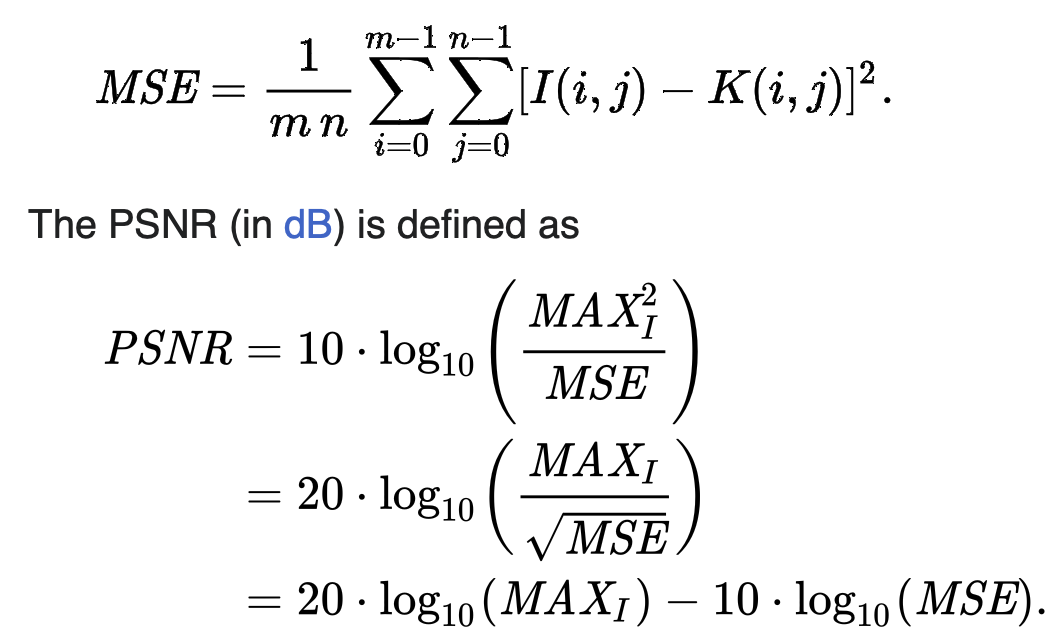

0 2.1246681213378906 secs per iter


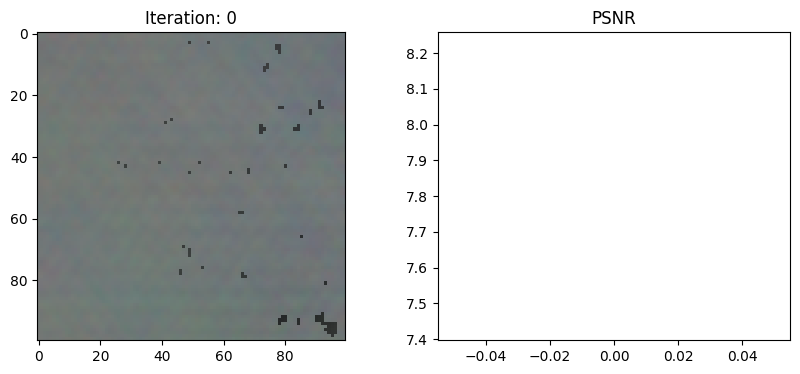

25 46.218236770629886 secs per iter


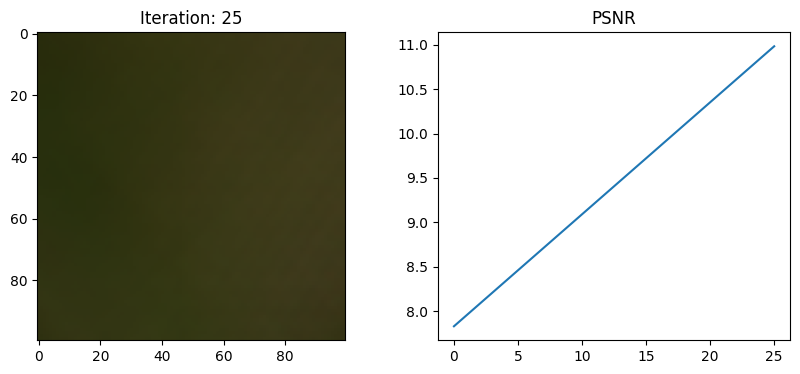

50 45.558996992111204 secs per iter


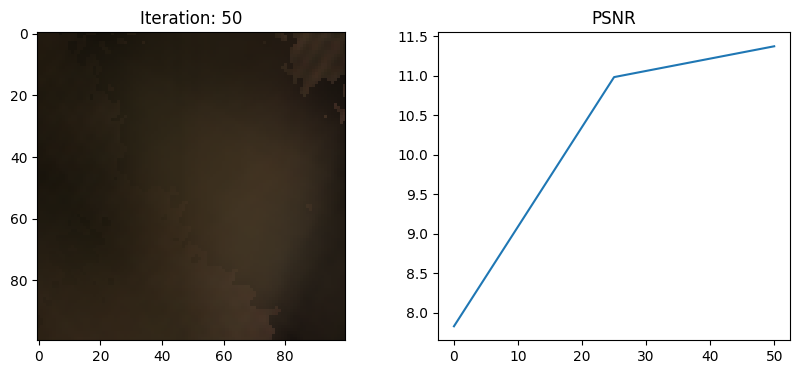

75 45.29182698249817 secs per iter


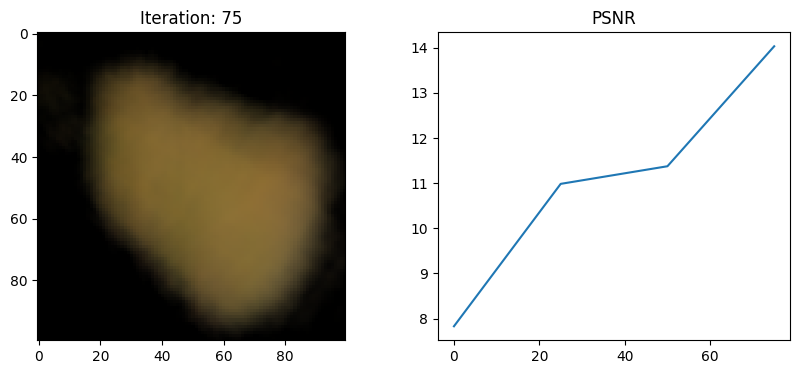

100 43.66995627403259 secs per iter


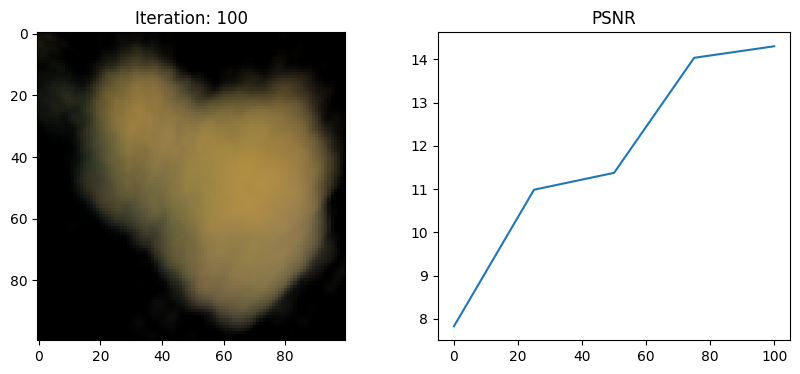

125 43.39452392578125 secs per iter


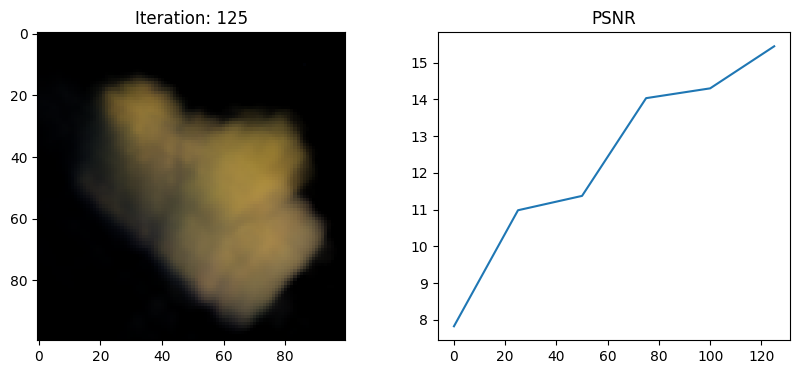

150 42.72715497016907 secs per iter


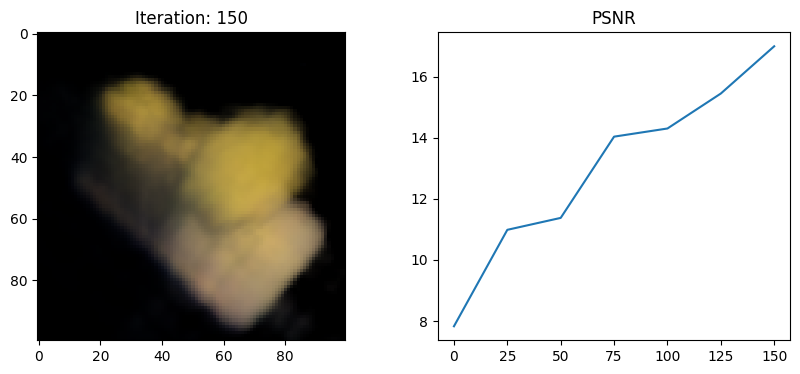

175 43.77320326805115 secs per iter


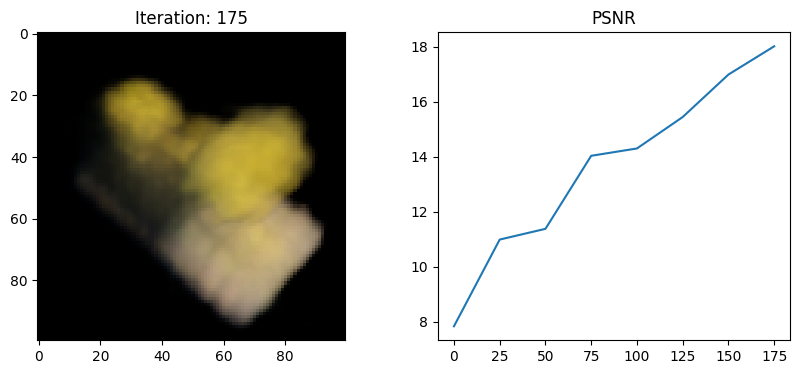

200 43.42832374572754 secs per iter


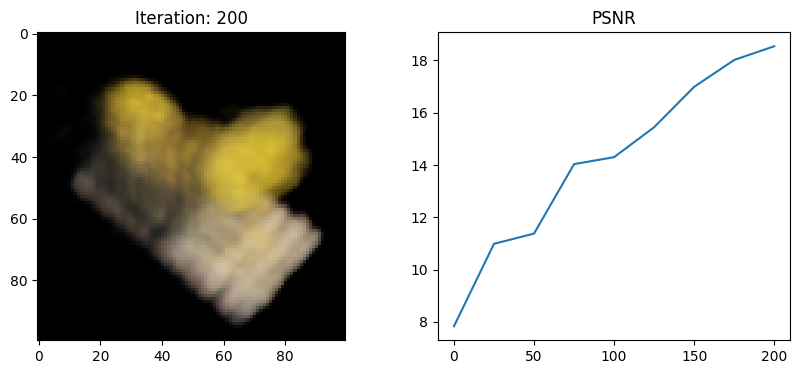

225 43.31224100112915 secs per iter


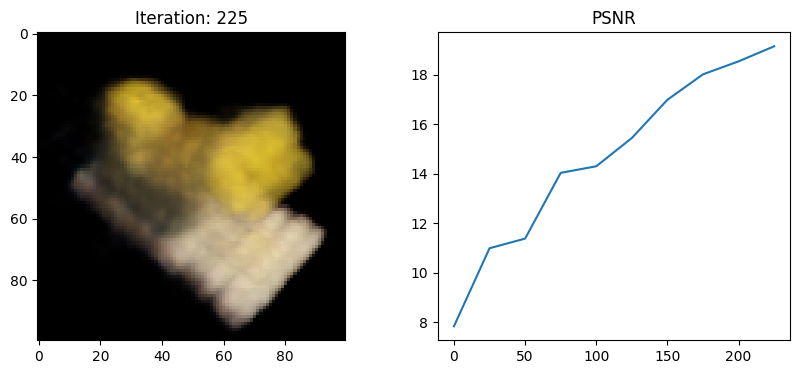

250 42.90932542800903 secs per iter


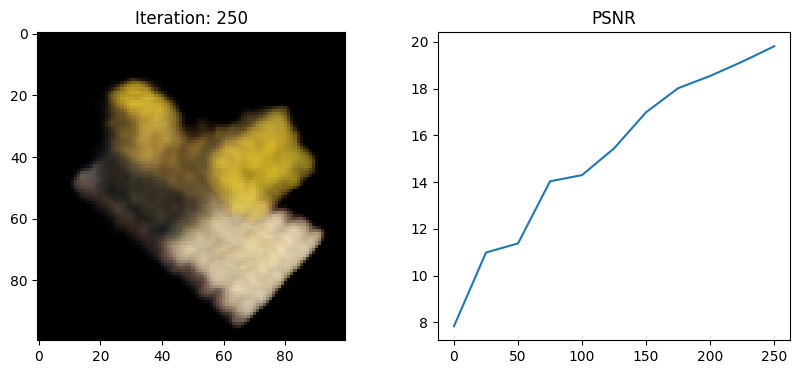

275 43.42896291732788 secs per iter


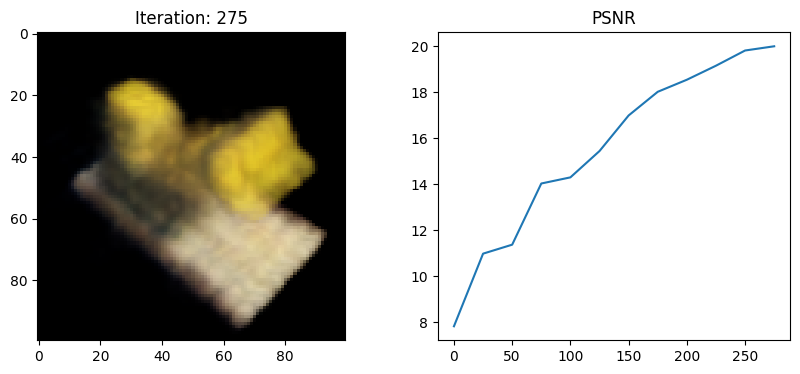

In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')